### Информация о датасетах

**Целевой признак первой задачи:**
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Целевой признак второй задачи:**
* `quit` — увольнение сотрудника из компании

**Входные признаки:**

* `id` — уникальный идентификатор сотрудника;

**Количественные признаки**

* `employment_years` — длительность работы в компании (в годах);
* `salary` — ежемесячная зарплата сотрудника;

**Категорийные признаки**

*Номинальный тип*

* `dept` — отдел, в котором работает сотрудник;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `last_year_promo` — показывает, было ли повышение за последний год;

*Порядковый тип*

* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;

### Задачи проекта

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Загрузка данных и собственные функции

### Импорт библиотек

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    OrdinalEncoder,  
    RobustScaler,
    MinMaxScaler,
    LabelEncoder

)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyRegressor

from sklearn.metrics import (
    r2_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error
)

from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance



from phik import phik_matrix
from phik.report import plot_correlation_matrix 
import warnings

### Импорт данных

### Собственные функции

In [4]:
RANDOM_STATE = 42

In [5]:
# Составление общего описания данных. На вход подается название датафрейма. Получаем количество 
# строк и столбцов датафрейма, пять рандомных строк, тип данных, количество пропусков 
# в каждом столбце, число уникальных значений и уникальные значения категорийных признаков
def data_description(df):
    print(f"Количество строк: {df.shape[0]}")  
    print(f"Количество столбцов: {df.shape[1]}") 
    print(f"Количество полных дубликатов: {df.duplicated(keep=False).sum()}")
    display(df.head()) 
    columns_info = pd.DataFrame({ 
        'Тип данных': df.dtypes, 
        'Количество пропусков': df.isna().sum(),
        'Уникальные значения': df.nunique()
    })
    display(columns_info)
    
    # Вывод уникальных значений для всех категориальных признаков
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения для столбца '{column}':")
        for value in unique_values:
            print(f' "{value}"')
        print()



In [6]:
# Построение диаграммы размаха и гистограммы для количественного признака.
# На вход подаются: название тренировочной выборки, тестовой выборки, подпись графиков по оси X.
# Получаем диаграммы размаха, гистограммы и описательные характеристики признака из заданных датафреймов 

# Построение диаграммы размаха и гистограммы для количественного признака.
# На вход подаются: название тренировочной выборки, тестовой выборки, подпись графиков по оси X.
# Получаем диаграммы размаха, гистограммы и описательные характеристики признака из заданных датафреймов 

def hist_and_boxplot(df_name1, df_name2, column, x_label):
    df1 = df_name1
    df2 = df_name2
    
    # Создаем фигуру для диаграммы размаха и гистограммы для первого датафрейма
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Распределение в тренировочной выборке по признаку '{column}'", fontsize=14, ha='center')
    
    # Ящик с усами для первого датафрейма
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df1[column], color='lightgreen', width=0.3)
    plt.xlabel(x_label)
    
    # Гистограмма распределения для первого датафрейма
    plt.subplot(1, 2, 2)
    sns.histplot(df1[column], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(x_label)
    plt.ylabel('Сотрудники')
    plt.grid(axis='y', alpha=0.75)
    
    plt.tight_layout()
    
    # Создаем фигуру для диаграммы размаха и гистограммы для второго датафрейма
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Распределение в тестовой выборке по признаку '{column}'", fontsize=14, ha='center')
    
    # Ящик с усами для второго датафрейма
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df2[column], color='lightgreen', width=0.3)
    plt.xlabel(x_label)
    
    # Гистограмма распределения для второго датафрейма
    plt.subplot(1, 2, 2)
    sns.histplot(df2[column], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(x_label)
    plt.ylabel('Сотрудники')
    plt.grid(axis='y', alpha=0.75)
    
    plt.tight_layout()
    
    # Результаты .describe() для df1[column] и df2[column]
    describe_df1 = df1[column].describe().round(2)
    describe_df2 = df2[column].describe().round(2)
    
    describe_combined = pd.concat([describe_df1, describe_df2], axis=1, keys=['df1', 'df2'])
    display(describe_combined)

In [7]:
# Построение диаграммы размаха и гистограммы для количественного признака. (сравнение классов)
# На вход подаются: название тренировочной выборки, тестовой выборки, подпись графиков по оси X.
# Получаем диаграммы размаха, гистограммы и описательные характеристики признака из заданных датафреймов 

# Построение диаграммы размаха и гистограммы для количественного признака.
# На вход подаются: название тренировочной выборки, тестовой выборки, подпись графиков по оси X.
# Получаем диаграммы размаха, гистограммы и описательные характеристики признака из заданных датафреймов 

def hist_and_boxplot2(df_name1, df_name2, column, x_label):
    df1 = df_name1
    df2 = df_name2
    
    # Создаем фигуру для диаграммы размаха и гистограммы для первого датафрейма
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Распределение по признаку '{column}' среди уволившихся", fontsize=14, ha='center')
    
    # Ящик с усами для первого датафрейма
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df1[column], color='lightgreen', width=0.3)
    plt.xlabel(x_label)
    
    # Гистограмма распределения для первого датафрейма
    plt.subplot(1, 2, 2)
    sns.histplot(df1[column], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(x_label)
    plt.ylabel('Сотрудники')
    plt.grid(axis='y', alpha=0.75)
    
    plt.tight_layout()
    
    # Создаем фигуру для диаграммы размаха и гистограммы для второго датафрейма
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Распределение по признаку '{column}' среди оставшихся", fontsize=14, ha='center')
    
    # Ящик с усами для второго датафрейма
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df2[column], color='lightgreen', width=0.3)
    plt.xlabel(x_label)
    
    # Гистограмма распределения для второго датафрейма
    plt.subplot(1, 2, 2)
    sns.histplot(df2[column], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(x_label)
    plt.ylabel('Сотрудники')
    plt.grid(axis='y', alpha=0.75)
    
    plt.tight_layout()
    
    # Результаты .describe() для df1[column] и df2[column]
    describe_df1 = df1[column].describe().round(2)
    describe_df2 = df2[column].describe().round(2)
    
    describe_combined = pd.concat([describe_df1, describe_df2], axis=1, keys=['df1', 'df2'])
    display(describe_combined)

In [8]:
# Построение круговой диаграммы для категориального признака
# На вход подаются: названия датафреймов и название столбца.
# Получаем круговые диаграммы для заданного признака с легендой и заголовками

def plot_pie_chart(df_name1, df_name2, column):
    # Получаем количество уникальных значений и общее количество записей для первого датафрейма
    values1 = df_name1[column].value_counts()
    total_count1 = df_name1[column].count()
    
    # Получаем количество уникальных значений и общее количество записей для второго датафрейма
    values2 = df_name2[column].value_counts()
    total_count2 = df_name2[column].count()
    
    # Создаем фигуру для двух круговых диаграмм
    plt.figure(figsize=(12, 5))
    
    # Строим круговую диаграмму для первого датафрейма
    plt.subplot(1, 2, 1)
    wedges1, texts1, autotexts1 = plt.pie(values1, 
                                          autopct=lambda p: f'{p:.1f}%\n({int(p/100*total_count1)})', 
                                          startangle=140, 
                                          textprops={'color': 'w', 'fontsize': 12, 'weight': 'bold'})
    plt.title(f'Тренировочная выборка', fontsize=14)

    # Строим круговую диаграмму для второго датафрейма
    plt.subplot(1, 2, 2)
    wedges2, texts2, autotexts2 = plt.pie(values2, 
                                          autopct=lambda p: f'{p:.1f}%\n({int(p/100*total_count2)})', 
                                          startangle=140, 
                                          textprops={'color': 'w', 'fontsize': 12, 'weight': 'bold'})
    plt.title(f'Тестовая выборка', fontsize=14)
    
    # Создаем общую легенду
    plt.legend(values1.index, title=None, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
    
    # Добавляем общий заголовок
    plt.suptitle(f"Распределение признака '{column}'", fontsize=16)
    
    # Отображаем обе круговые диаграммы
    plt.tight_layout()
    plt.show()


In [9]:
# Построение круговой диаграммы для категориального признака (сравнение классов)
# На вход подаются: названия датафреймов и название столбца.
# Получаем круговые диаграммы для заданного признака с легендой и заголовками

def plot_pie_chart2(df_name1, df_name2, column):
    # Получаем количество уникальных значений и общее количество записей для первого датафрейма
    values1 = df_name1[column].value_counts()
    total_count1 = df_name1[column].count()
    
    # Получаем количество уникальных значений и общее количество записей для второго датафрейма
    values2 = df_name2[column].value_counts()
    total_count2 = df_name2[column].count()
    
    # Создаем фигуру для двух круговых диаграмм
    plt.figure(figsize=(12, 5))
    
    # Строим круговую диаграмму для первого датафрейма
    plt.subplot(1, 2, 1)
    wedges1, texts1, autotexts1 = plt.pie(values1, 
                                          autopct=lambda p: f'{p:.1f}%\n({int(p/100*total_count1)})', 
                                          startangle=140, 
                                          textprops={'color': 'w', 'fontsize': 12, 'weight': 'bold'})
    plt.title(f'Уволившиеся', fontsize=14)

    # Строим круговую диаграмму для второго датафрейма
    plt.subplot(1, 2, 2)
    wedges2, texts2, autotexts2 = plt.pie(values2, 
                                          autopct=lambda p: f'{p:.1f}%\n({int(p/100*total_count2)})', 
                                          startangle=140, 
                                          textprops={'color': 'w', 'fontsize': 12, 'weight': 'bold'})
    plt.title(f'Работающие', fontsize=14)
    
    # Создаем общую легенду
    plt.legend(values1.index, title=None, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
    
    # Добавляем общий заголовок
    plt.suptitle(f"Распределение признака '{column}'", fontsize=16)
    
    # Отображаем обе круговые диаграммы
    plt.tight_layout()
    plt.show()

In [10]:
# Построение столбчатой диаграммы для категориального признака
# На вход подаются: названия датафреймов и название столбца.
# Получаем столбчатые диаграммы для заданного признака с подписями данных и заголовками

def plot_dual_bar_chart(df1, df2, column, xlabel):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    plt.suptitle(f"Распределение признака '{column}'", fontsize=14)
    
    for ax, df in zip(axs, [df1, df2]):
        values = df[column].value_counts().sort_index(ascending=False)
        total_count = df[column].count()
        bars = ax.bar(range(len(values)), values, color='skyblue' if ax == axs[0] else 'lightcoral')
        ax.set_title('Тренировочная выборка' if ax == axs[0] else 'Тестовая выборка', fontsize=13)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Сотрудники')
        
        for i, (index, value) in enumerate(values.sort_index(ascending=False).items()):
            abs_value = value
            percent_value = value / total_count * 100
            ax.text(i, value + 5, f'{abs_value} ({percent_value:.1f}%)', ha='center', va='bottom', fontsize=10)
        
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels(values.index)
    
    plt.tight_layout()
    plt.show()

In [11]:
# Определяет, есть ли в датасетах строки с пересечениями по id
def count_common_ids(df1, df2):
    common_ids = set(df1['id']).intersection(set(df2['id']))
    
    if not common_ids:
        print("Пересечения по id в датафреймах отсутствуют")
        return []
    
    count_common = len(common_ids)
    print(f"Количество пересечений id между датафреймами: {count_common}")
    
    return list(common_ids)

# Часть первая: предсказание уровня удовлетворённости сотрудника

## Описание и предобработка данных

Изучим общую информацию об имеющихся датасетах. Проверим их на соответствие описанию, наличие пропусков и дубликатов, а также на корректность типа данных данных.

### Датасет `train_satisfaction`

In [12]:
data_description(train_satisfaction)

Количество строк: 4000
Количество столбцов: 10
Количество полных дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,Тип данных,Количество пропусков,Уникальные значения
id,int64,0,4000
dept,object,6,5
level,object,4,3
workload,object,0,3
employment_years,int64,0,10
last_year_promo,object,0,2
last_year_violations,object,0,2
supervisor_evaluation,int64,0,5
salary,int64,0,68
job_satisfaction_rate,float64,0,98


Уникальные значения для столбца 'dept':
 "sales"
 "hr"
 "technology"
 "purchasing"
 "marketing"
 "nan"

Уникальные значения для столбца 'level':
 "junior"
 "middle"
 "sinior"
 "nan"

Уникальные значения для столбца 'workload':
 "medium"
 "high"
 "low"

Уникальные значения для столбца 'last_year_promo':
 "no"
 "yes"

Уникальные значения для столбца 'last_year_violations':
 "no"
 "yes"



**Вывод по датасету `train_satisfaction`**

1. Датасет состоит из 4000 строк и 10 столбцов. Набор признаков и их значения соответствуют описанию.
2. В столбцах `dept` и `level` имеются пропуски. 
3. Типы данных корректные.
4. Полные дубли отсутствуют.
5. Дублирования в уникальных значениях категорийных признаков отсутствует.
6. Есть опечатка в значении `sinior`, которую можно исправить, но она не повлияла бы на обучение модели, так как не дублирует другое значение признака `level`.
7. Названия столбцов соответствуют стандартам оформления.

### Датасет `X_test_satisfaction`

In [13]:
data_description(X_test_satisfaction)

Количество строк: 2000
Количество столбцов: 9
Количество полных дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,Тип данных,Количество пропусков,Уникальные значения
id,int64,0,2000
dept,object,2,6
level,object,1,3
workload,object,0,4
employment_years,int64,0,10
last_year_promo,object,0,2
last_year_violations,object,0,2
supervisor_evaluation,int64,0,5
salary,int64,0,66


Уникальные значения для столбца 'dept':
 "marketing"
 "hr"
 "sales"
 "purchasing"
 "technology"
 "nan"
 " "

Уникальные значения для столбца 'level':
 "junior"
 "middle"
 "sinior"
 "nan"

Уникальные значения для столбца 'workload':
 "medium"
 "low"
 "high"
 " "

Уникальные значения для столбца 'last_year_promo':
 "no"
 "yes"

Уникальные значения для столбца 'last_year_violations':
 "no"
 "yes"



**Вывод по датасету `X_test_satisfaction`**

1. Датасет состоит из 2000 строк и 9 столбцов. Набор признаков и их значения соответствуют описанию.
2. В столбцах `dept` и `level` имеются пропуски. 
3. Типы данных корректные.
4. Полные дубли отсутствуют.
5. Имеются пробелы " " в качестве значений в столбцах `workload` и `dept`.
6. Есть опечатка в значении `sinior`, которую можно исправить, но она не повлияла бы на обучение модели, так как не дублирует другое значение признака `level`.
7. Названия столбцов соответствуют стандартам оформления.


### Датасет `y_test_satisfaction`

In [14]:
data_description(y_test_satisfaction)

Количество строк: 2000
Количество столбцов: 2
Количество полных дубликатов: 0


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,Тип данных,Количество пропусков,Уникальные значения
id,int64,0,2000
job_satisfaction_rate,float64,0,98


**Вывод по датасету `y_test_satisfaction`**

1. Датасет состоит из 2000 строк и 2 столбцов. Набор признаков и их значения соответствуют описанию.
2. Пропуски отсутствуют. 
3. Типы данных корректные.
4. Названия столбцов соответствуют стандартам оформления

Убедимся, что в тренировочных и тестовых данных нет одинаковых работников. Проверим совпадения по id:

In [15]:
display(common_ids_1 = count_common_ids(train_satisfaction, y_test_satisfaction))
common_ids_2 = count_common_ids(train_satisfaction, X_test_satisfaction)

Пересечения по id в датафреймах отсутствуют
Пересечения по id в датафреймах отсутствуют


### Предобработка данных

Посмотрим на строки с пропусками в тренировочной выборке:

In [16]:
train_na = train_satisfaction[train_satisfaction.isnull().any(axis=1)]
train_na

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Пропущенные значения наблюдаются в 10 строках, что составляет 0,25% от общей выборки. Так как строк с пропусками ничтожно мало и мы не можем адекватно заполнить их, удалим их из выборки. Качество будущей модели при этом не пострадает.

In [17]:
train_satisfaction.dropna(axis=0, inplace=True)

In [18]:
ids = [1209, 1469, 1526, 1630, 1633, 1745, 2522, 2781, 2975, 3866]

train_satisfaction = train_satisfaction[~train_satisfaction['id'].isin(ids)]

# Проверяем размерности получившихся датафреймов
train_satisfaction.shape


(3990, 10)

Оценим строки с пропусками и пробелом " " в тестовой выборке:

In [19]:
test_na = X_test_satisfaction[(X_test_satisfaction == ' ').any(axis=1) | X_test_satisfaction.isnull().any(axis=1)]
test_na

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


In [20]:
X_test_satisfaction['dept'] = (X_test_satisfaction['dept']
                               .replace(' ', np.nan)
                               .fillna(X_test_satisfaction['dept'].mode()[0]))

X_test_satisfaction['workload'] = (X_test_satisfaction['workload']
                               .replace(' ', np.nan)
                               .fillna(X_test_satisfaction['workload'].mode()[0]))

X_test_satisfaction['level'] = (X_test_satisfaction['level']
                               .replace(' ', np.nan)
                               .fillna(X_test_satisfaction['level'].mode()[0]))


display(X_test_satisfaction[(X_test_satisfaction == ' ').any(axis=1) | X_test_satisfaction.isnull().any(axis=1)].count())
X_test_satisfaction.shape

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

(2000, 9)

Заодно исправим ошибку в грейде:

In [21]:
train_satisfaction['level'] = train_satisfaction['level'].replace('sinior', 'senior')
X_test_satisfaction['level'] = X_test_satisfaction['level'].replace('sinior', 'senior')

display(train_satisfaction['level'].unique())
X_test_satisfaction['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

array(['junior', 'middle', 'senior'], dtype=object)

### Вывод

Выполнен первичный анализ и предобработка полученных данных:

1. Содержимое датасетов совпадает с описанием. Названия столбцов соответствуют стандартам оформления.  
2. Тренировочная выборка состоит из 4000 сотрудников, а тестовая — из 2000.
3. В обеих выборках имеются строки с пропусками в столбцах `dept` и `level`, а также пробелы " " вместо значений в столбцах `workload` и `dept`. Пропуски заменены на самые частые значения.
4. Полные дубли отсутствуют в обеих выборках. Проверка уникальных значений категорийных данных показала отсутствие неявных дублей. Попутно в столбце `level` исправлена ошибка в значении `senior`.
5. Типы данных во всех трех датасетах корректные.

В рамках задачи по предобработке данных осталась проверка на наличие аномальных значений, которая будет выполнена в процессе исследовательского анализа данных. 

## Исследовательский анализ данных

### Целевой признак: `job_satisfaction_rate`

,df1,df2
count,3990.00,2000.00
mean,0.53,0.55
std,0.23,0.22
min,0.03,0.03
25%,0.36,0.38
50%,0.56,0.58
75%,0.71,0.72
max,1.00,1.00


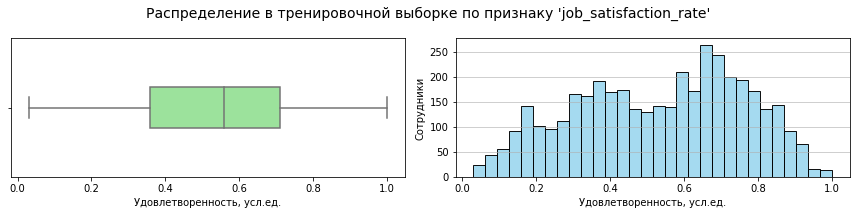

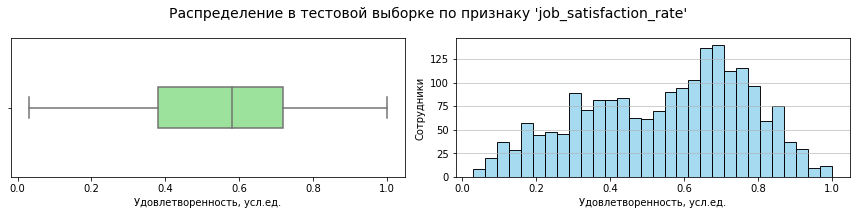

In [22]:
hist_and_boxplot(train_satisfaction, y_test_satisfaction, 'job_satisfaction_rate', 'Удовлетворенность, усл.ед.')

1. Диапазон признака: от 0.03 до 1
2. Аномальные значения в выборках отсутствуют.
3. Характер распределения тренировочной и тестовой выборок схож, что может говорить о том, что деление на выборки провели корректно.
4. Медианное значение тренировочной выборки — 0.56, среднее — 0.53. 
5. На графиках прослеживается мультимодальность. 


### Длительность работы в компании `employment_years`

,df1,df2
count,3990.00,2000.00
mean,3.72,3.67
std,2.54,2.54
min,1.00,1.00
25%,2.00,1.00
50%,3.00,3.00
75%,6.00,6.00
max,10.00,10.00


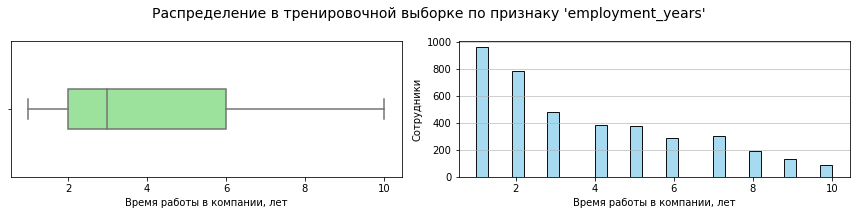

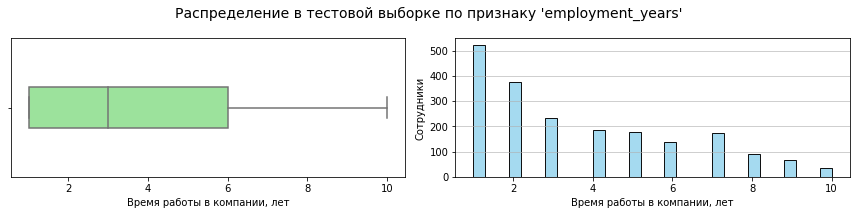

In [23]:
hist_and_boxplot(train_satisfaction, X_test_satisfaction, 'employment_years', 'Время работы в компании, лет')

1. Сотрудники раюлотают в компании от 1 до 10 лет.
2. Аномальные значения в выборках отсутствуют.
3. Среднее значение признака больше медианы, что обуславливается асимметричностью распределения. 
4. В тренировочной выборке медиана равна 3 годам, а среднее 3.72 года. 

### Ежемесячная зарплата сотрудника `salary`

,df1,df2
count,3990.00,2000.00
mean,33953.38,34066.80
std,14907.25,15398.44
min,12000.00,12000.00
25%,22800.00,22800.00
50%,30000.00,30000.00
75%,43200.00,43200.00
max,98400.00,96000.00


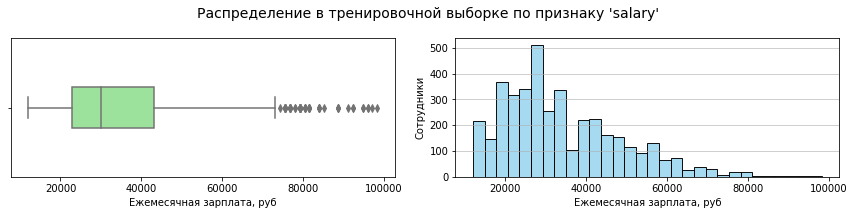

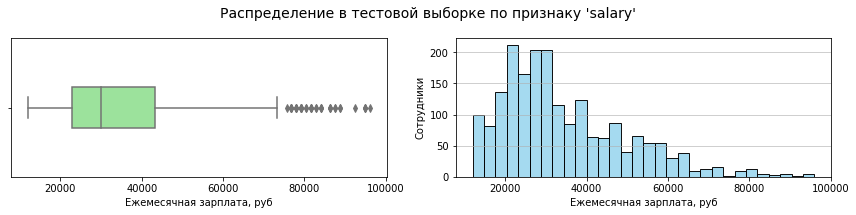

In [24]:
hist_and_boxplot(train_satisfaction, X_test_satisfaction, 'salary', 'Ежемесячная зарплата, руб')

1. Диапазон признака: от 12 000 рублей до 98 400 в тренировочной и 96 000 в тестовой выборке.
2. График показывает выбросы, но такие значения не являются аномальными, поэтому оставим их в выборках.
3. Медианное обеих выборок — 30 000 рублей. 
4. Ожидаемо, наблюдается правосторонняя асимметрия.  

### Отдел `dept`

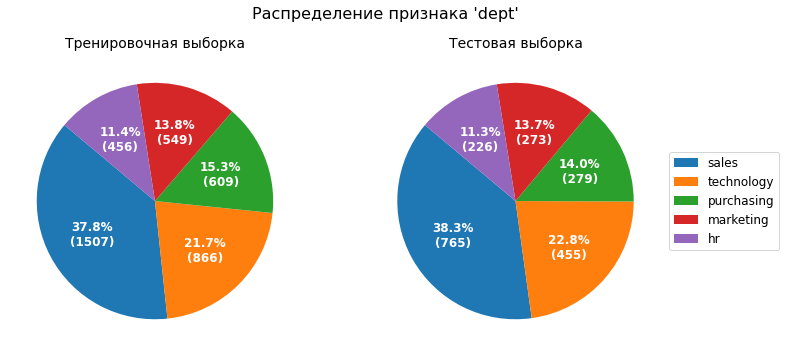

In [25]:
plot_pie_chart(train_satisfaction, X_test_satisfaction, 'dept')

1. Соотношения значений признака с тренировочной и тестовой выборках похожи, деление было выполнено корректно.
2. Ошибочные и пропущенные значения отсутствуют.
3. Большая часть сотрудников представляет отдел продаж. Меньше всего в выборке сотрудников из отдела HR.

### Нарушение трудового договора `last_year_violations`

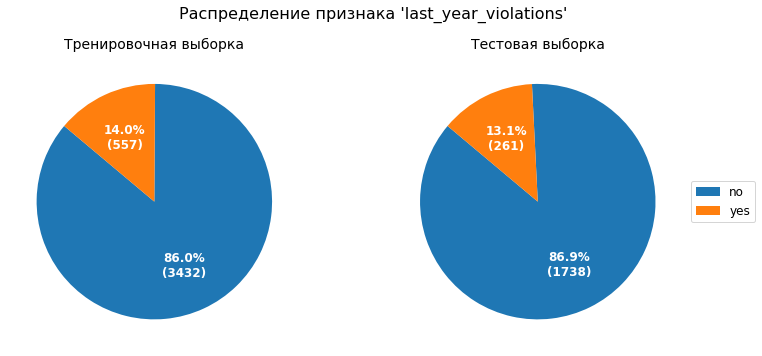

In [26]:
plot_pie_chart(train_satisfaction, X_test_satisfaction, 'last_year_violations')

Трудовой договор нарушали 14% и 13.1% сотрудников. 

### Повышение `last_year_promo`

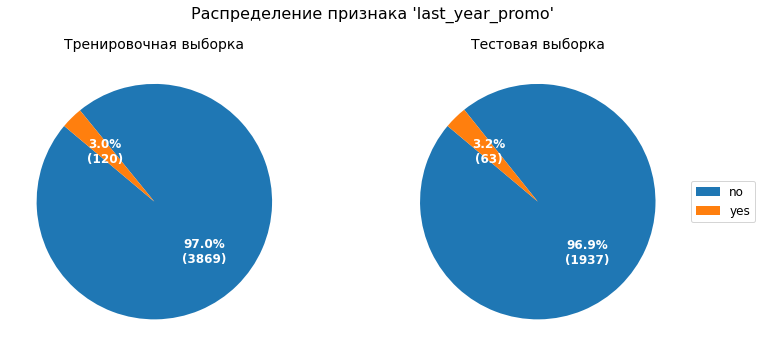

In [27]:
plot_pie_chart(train_satisfaction, X_test_satisfaction, 'last_year_promo')

Похвастаться повышением в этом году могут лишь 3 и 3.3% сотрудников. 

### Оценка качества работы `supervisor_evaluation`

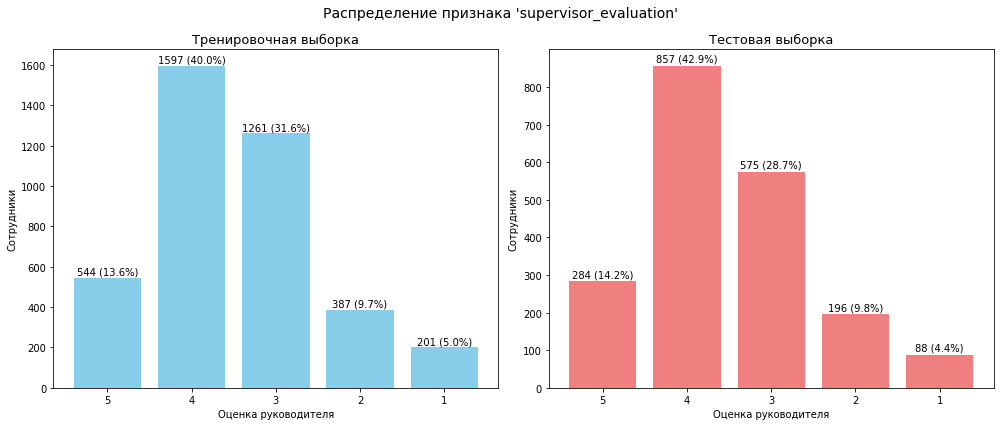

In [28]:
plot_dual_bar_chart(train_satisfaction, X_test_satisfaction, 'supervisor_evaluation', 'Оценка руководителя')

1. Самая частая оценка сотрудника от руководителя — это четверка (40% и 42.8%). Имеются и счастливчики колом —  5% и 4.4%.
2. Распределения в выборках похожи друг на друга.
3. Аномальные и некорректные значения отсутствуют.

### Уровень должности `level`

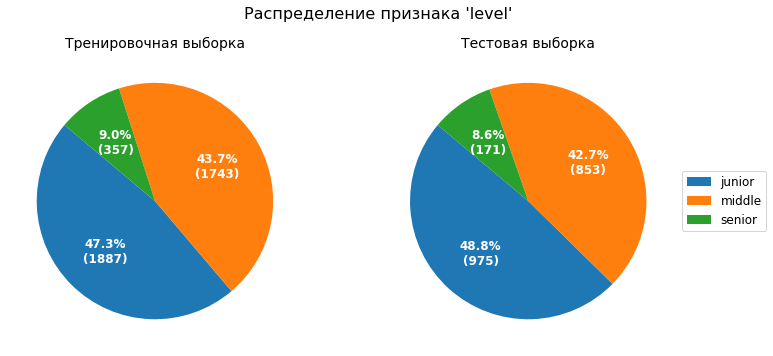

In [29]:
plot_pie_chart(train_satisfaction, X_test_satisfaction, 'level')

Почти половина сотрудников в выборках имеют уровень junior. Меньше всего сотрудников уровня senior (9% и 8.6%)


### Уровень загруженности `workload`

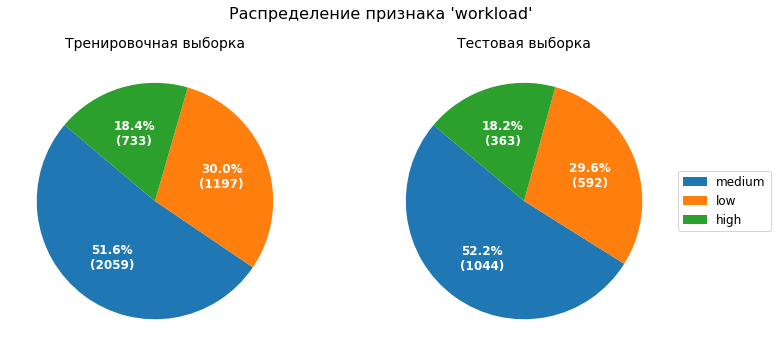

In [30]:
plot_pie_chart(train_satisfaction, X_test_satisfaction, 'workload')

Около половины сотрудников имеют среднюю нагрузку. До 30% сотрудников работают в легком режиме. И ~18% сотрудников имеют высокую  нагрузку.


### Выводы

1. Построены графики распределения признаков в тренировочной и тестовой выборках: гистограммы и диаграммы размаха для количественных, а также столбчатые и круговые диаграммы для категорийных. Оценены описательные характеристики у количественных показателей.

2. Аномальные значения отсутствуют в обеих выборках. 

3. Перед поиском и обучением лучшей модели осталось закодировать категорийные признаки, учитывая их подтип, и масштабировать количественные.

4. Количественные признаки, которые мы будем масштабировать: `job_satisfaction_rate`, `employment_years` и `salary`. Категорийные номинальные признаки, которые необходимо закодировать методом OneHotEncoder: `dept`, `last_year_violations`, `last_year_promo`. Категорийные ранговые методом OrdinalEncoder: `supervisor_evaluation`, `level`, `workload`.



## Корреляционный анализ данных

Перед тем как перейти на этап кодирования и масштабирования, рассмотрим взаимосвязи между признаками в тренировочной выборке. Дублировать расчеты на тестовую выборку не будем, поскольку ранее убедились, что структура выборок похожая.

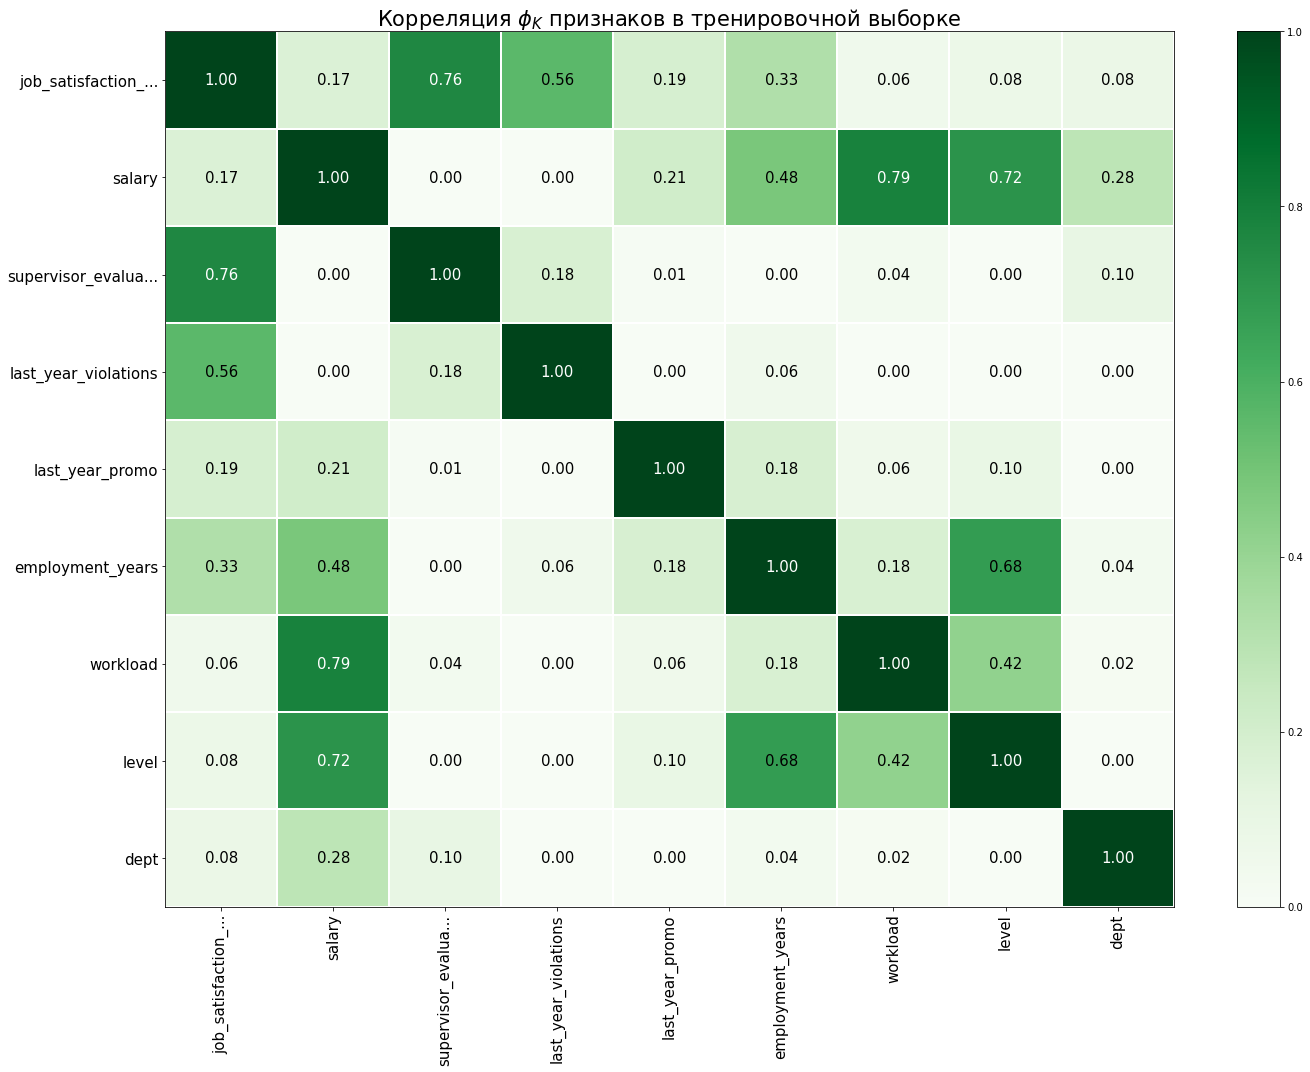

In [31]:
interval_cols = ['job_satisfaction_rate', 'employment_years', 'salary']
phik_overview = train_satisfaction.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

# строим тепловую карту
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$ признаков в тренировочной выборке',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Выводы
1. Наблюдаем высоку корреляцию между показателем удовлетворенности `job_satisfaction_rate` и оценкой качества работы `supervisor_evaluation`. 
2. Также присутствует заметная взаимосвязь между удовлетворенностью и наличием нарушений трудового договора. 
3. Умеренная, но ожидаемая связь имеется между удовлетворенностью и длительностью работы в компании, что вполне логично
4. Почти отсутствует взаимосвязь между удовлетворенностью и зарплатой
5. Зарплата сильно взаимосвязана с загрузкой и грейдом, а также умеренно с длительностью работы в компании.
6. Грейд ожидаемо взаимосвязан с длительностью и загрузкой.
7. Интересно, что оценка руководства сильно коррелирует только с показателем удовлетворенности сотрудника. Слабая взаимосвязь имеется с наличием нарушений. От других признаков оценка практически не зависит.
8. Признаки, которые меньше всего связаны с остальными — это наличие повышений и отдел.
9. **Мультимодальность** отсутствует, поэтому сохраним в датасете все признаки.

## Подготовка данных

Переведем значения id в индексы в тренировочном датасете и посмотрим на количество полных дублей. 

In [32]:
train_satisfaction.set_index('id', inplace=True)
print('Количество дубликатов:',train_satisfaction.duplicated().sum())

Количество дубликатов: 245


Удалим дубликаты из тренировочной выборки, так как их наличие может привести к искусственному увеличению веса некоторых признаков, выбору менее эффективной модели и лишним затратам ресурсов

In [33]:
train_satisfaction = train_satisfaction.drop_duplicates()
train_satisfaction.shape

(3745, 9)

Выделим входные и целевой признаки в отдельные датасеты

In [34]:
X_train = train_satisfaction.drop(['job_satisfaction_rate'], axis=1).sort_index()
y_train = train_satisfaction['job_satisfaction_rate'].to_frame().sort_index()
display(X_train.sort_index().head())
y_train.sort_index().head()


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600
101057,sales,junior,low,1,no,yes,4,19200
101074,sales,junior,medium,2,no,no,2,20400
101081,sales,middle,low,2,no,no,4,28800
101129,technology,junior,medium,1,no,no,4,34800


,job_satisfaction_rate
id,
100954,0.60
101057,0.45
101074,0.36
101081,0.66
101129,0.71


Переведем значения id в индексы в тестовых данных 

In [35]:
X_test = X_test_satisfaction.set_index('id').copy().sort_index()
y_test = y_test_satisfaction.set_index('id').copy().sort_index()

In [36]:
display(X_test.sort_index().head())
y_test.sort_index().head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


## Промежуточные выводы

Ранее мы рассмотрели 3 датасета от заказчика: тренировочные данные `train_satisfaction`, входные признаки `X_test_satisfaction` и целевой признак тестовых данных `y_test_satisfaction`. 

Выполнена предобработка данных: заполнены пропуски в данных, включая неявные, а также исправлена небольшая опечатка в значении столбца `level`. Переведены в индексы `id` сотрудников. После этого из тренировочной выборки удалены полные дубликаты, чтобы избежать снижения качества модели.

Провелен исследовательский анализ данных. Рассмотрены графики и описательные характеристики для тренировочной и тестовой выборок. 

Оценена взаимосвязь между удовлетворенностью работой и входными признаками. Наибольшая корреляция имеется с признаком `supervisor_evaluation`. Также присутствует заметная взаимосвязь между удовлетворенностью и наличием нарушений трудового договора. Удовлетворенность не зависит от отдела, в котором работает сотрудник. Также сделан вывод, что утечка данных отсутствует и все признаки можно использовать для обучения.

Вывод: данные адекватные, аномальные значения отсутствуют и датасеты готовы к обучению модели.  

## Поиск и обучение модели

In [37]:
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['salary', 'employment_years']

In [38]:
# создаём пайплайн для OHE-кодирования

ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse_output=False)
        )
    ]
)

In [39]:
# создаём пайплайн для Ordinal-кодирования 

ord_pipe = Pipeline(
    [
        (
            'ord', 
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5]
                    
                ], 
                handle_unknown='use_encoded_value', 
                unknown_value=np.nan
            )
        )
    ]
)

In [40]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [41]:
# создаём общий пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [42]:
def smape(y_test, y_pred):
    return 100 * np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred)))

smape_scorer = make_scorer(smape, greater_is_better=False)
warnings.filterwarnings('ignore')

In [43]:
param_grid = [   
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_leaf': range(2, 8),
        'models__max_depth': range(5, 10),
        'models__max_features': range(5, 10)
    },
    {
        'models': [LinearRegression()]
    }
]

In [44]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_violations',
                                                                          'last_year_promo',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[['junior',
                                                                                                                      'middle',
                                                                                                                      'senior'],
                                                                                                                     ['low',
                                                                                                                      'medium',...
                                                                          'employment_years'])])),
                                       ('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 10),
                          'models__max_features': range(5, 10),
                          'models__min_samples_leaf': range(2, 8)},
                         {'models': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [45]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', (grid.best_score_*-1).round(3))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                               

In [46]:
y_pred_test = grid.best_estimator_.predict(X_test)
smape_test = smape(y_test, y_pred_test)
print ("Метрика SMAPE на тестовой выборке равна:", smape_test['job_satisfaction_rate'].round(3))


Метрика SMAPE на тестовой выборке равна: 11.782


In [47]:
dummy_regr = DummyRegressor(strategy="mean")
# обучаем модель
dummy_regr.fit(X_test, y_test)
# предсказываем значения
y_pred_dummy = np.full_like(y_test, np.mean(y_test))

smape_test = smape(y_test, y_pred_dummy)

print ("Метрика SMAPE на тестовой выборке равна:", smape_test['job_satisfaction_rate'].round(3))

Метрика SMAPE на тестовой выборке равна: 18.903


Значение SMAPE у нашей модели лучше, чем у константной модели, значит она работает лучше, чем модель, которая всегда предсказывает среднее значение.

### Выводы

Создан пайплайн для поиска лучшей модели. Рассматривались 2 модели: DecisionTreeClassifier() и LogisticRegression(). Лучшей оказалась модель линейной регрессии. 

Метрика SMAP лучшей модели на валидационной выборке: 12.497
Метрика SMAPE на тестовой выборке равна: 11.782

# Часть вторая: предсказание увольнения сотрудника из компании

## Загрузка данных

In [48]:
# загружаем данные и сохраняем в переменные
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    X_test_quit = X_test_satisfaction
    y_test_quit = pd.read_csv('/datasets/test_target_quit.csv')
    
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    X_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    y_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')


## Описание данных

### Датасет `train_quit`

In [49]:
data_description(train_quit)

Количество строк: 4000
Количество столбцов: 10
Количество полных дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,Тип данных,Количество пропусков,Уникальные значения
id,int64,0,4000
dept,object,0,5
level,object,0,3
workload,object,0,3
employment_years,int64,0,10
last_year_promo,object,0,2
last_year_violations,object,0,2
supervisor_evaluation,int64,0,5
salary,int64,0,69
quit,object,0,2


Уникальные значения для столбца 'dept':
 "sales"
 "purchasing"
 "marketing"
 "technology"
 "hr"

Уникальные значения для столбца 'level':
 "middle"
 "junior"
 "sinior"

Уникальные значения для столбца 'workload':
 "high"
 "medium"
 "low"

Уникальные значения для столбца 'last_year_promo':
 "no"
 "yes"

Уникальные значения для столбца 'last_year_violations':
 "no"
 "yes"

Уникальные значения для столбца 'quit':
 "no"
 "yes"



Скорректируем ошибку в грейде

In [50]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

**Вывод по датасету `train_quit`**

1. Датасет состоит из 4000 строк и 10 столбцов. Набор признаков и их значения соответствуют описанию.
2. В столбцах `dept` и `level` имеются пропуски. 
3. Типы данных корректные.
4. Полные дубли отсутствуют.
5. Дублирования в уникальных значениях категорийных признаков отсутствует.
6. Есть опечатка в значении `sinior`, которую можно исправить, но она не повлияла бы на обучение модели, так как не дублирует другое значение признака `level`.
7. Названия столбцов соответствуют стандартам оформления.

### Датасет `X_test_quit`

Датасет рассмотрен и обработан в первой задаче.

### Датасет `y_test_quit`

In [51]:
data_description(y_test_quit)

Количество строк: 2000
Количество столбцов: 2
Количество полных дубликатов: 0


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,Тип данных,Количество пропусков,Уникальные значения
id,int64,0,2000
quit,object,0,2


Уникальные значения для столбца 'quit':
 "yes"
 "no"



**Вывод по датасету `y_test_quit`**

1. Датасет состоит из 1995 строк и 2 столбцов. Набор признаков и их значения соответствуют описанию.
2. Пропуски отсутствуют. 
3. Типы данных корректные.
4. Названия столбцов соответствуют стандартам оформления

Убедимся, что в тренировочных и тестовых данных нет одинаковых работников. Проверим совпадения по id:

In [52]:
display(common_ids_3 = count_common_ids(train_quit, y_test_quit))
common_ids_4 = count_common_ids(train_quit, X_test_quit)

Пересечения по id в датафреймах отсутствуют
Пересечения по id в датафреймах отсутствуют


## Исследовательский анализ данных

### Целевой признак: `quit`

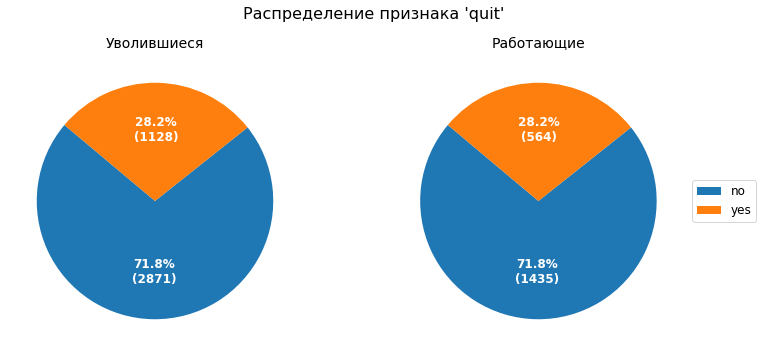

In [53]:
plot_pie_chart2(train_quit, y_test_quit, 'quit')

1. Отмечается дисбаланс классов. Деление данных на выборки было выполнено корректно, с учетом стратификации. Так как нам нужны точные предсказания именно по минорному классу, нужно выбрать способ устранения баланса при выборе модели. 

Далее будем сравнивать класс `no` и `yes` на тренировочной выборке, чтобы составить портрет уволившегося сотрудника.

In [54]:
train_yes = train_quit[train_quit['quit'] == 'yes']
train_no = train_quit[train_quit['quit'] == 'no']

### Длительность работы в компании `employment_years`

,df1,df2
count,1128.00,2872.00
mean,1.84,4.43
std,1.27,2.54
min,1.00,1.00
25%,1.00,2.00
50%,1.00,4.00
75%,2.00,6.00
max,10.00,10.00


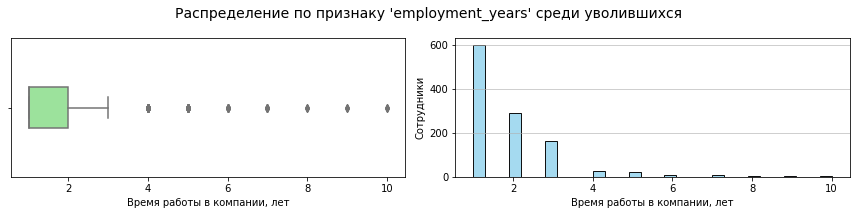

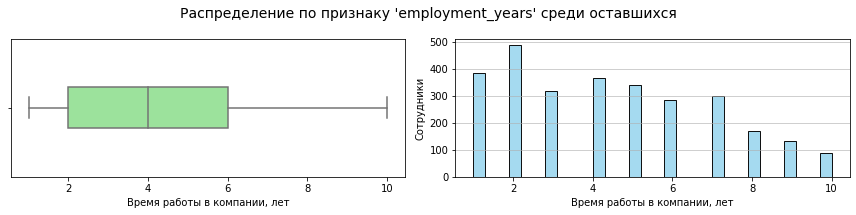

In [55]:
hist_and_boxplot2(train_yes, train_no, 'employment_years', 'Время работы в компании, лет')


Видна закономерность, что если сотрудник проработал больше 2-3, то возрастает вероятность, что он останется еще на несколько лет. Среди уволившихся медианное значение длительности работы составляет всего 1 год, в то время как среди оставшихся медианное значение 4 года. Среди уволенных настолько мало долгожителей, что на диаграмме размаха значения больше 4 являются выбросами

### Ежемесячная зарплата сотрудника `salary`

,df1,df2
count,1128.00,2872.00
mean,23885.11,37702.23
std,9351.60,15218.98
min,12000.00,12000.00
25%,16800.00,25200.00
50%,22800.00,34800.00
75%,27600.00,46800.00
max,79200.00,96000.00


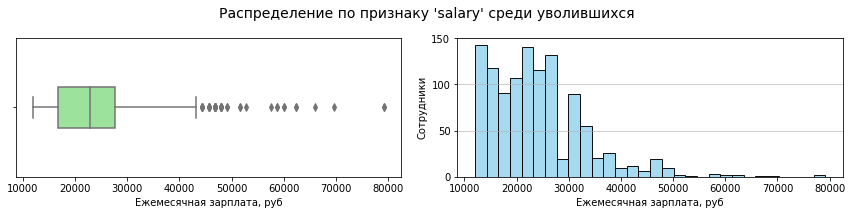

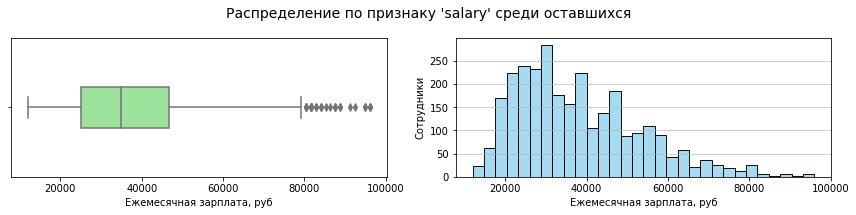

In [56]:
hist_and_boxplot2(train_yes, train_no, 'salary', 'Ежемесячная зарплата, руб')


Медианная зарплата уволившихся сотрудников ощутимо ниже, чем у оставшихся сотрудников. Диапазон для уволенных от 12 000 до 79 200 рублей, в то времякаку оставишхся от 12 000 до 96 000 рублей.

### Отдел `dept`

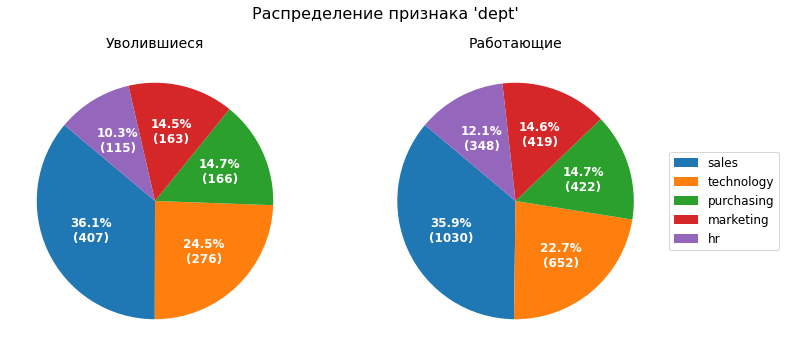

In [57]:
plot_pie_chart2(train_yes, train_no, 'dept')

Для этого признака нет какой-то определенной закономерности. 

### Нарушение трудового договора `last_year_violations`


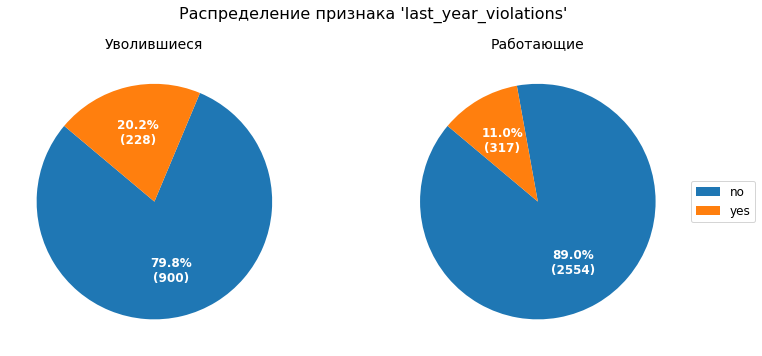

In [58]:
plot_pie_chart2(train_yes, train_no, 'last_year_violations')

Вполне ожидаемо доля нарушителей среди уволенных почти вдвое больше, чем среди работающих сотрудников.

### Повышение `last_year_promo`

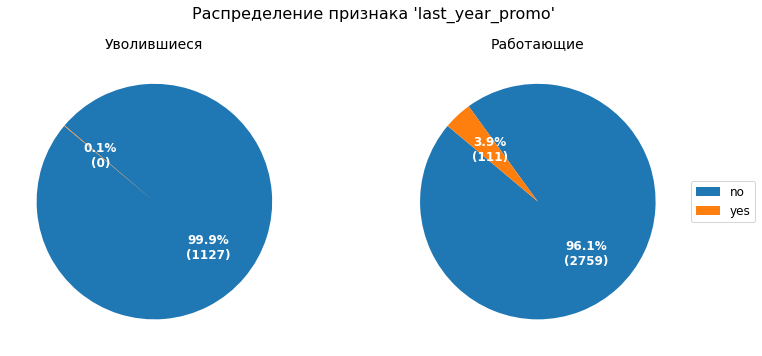

In [59]:
plot_pie_chart2(train_yes, train_no, 'last_year_promo')

Среди уволенных сотрудников нет тех, кто получал повышение за последний год.

### Оценка качества работы `supervisor_evaluation`

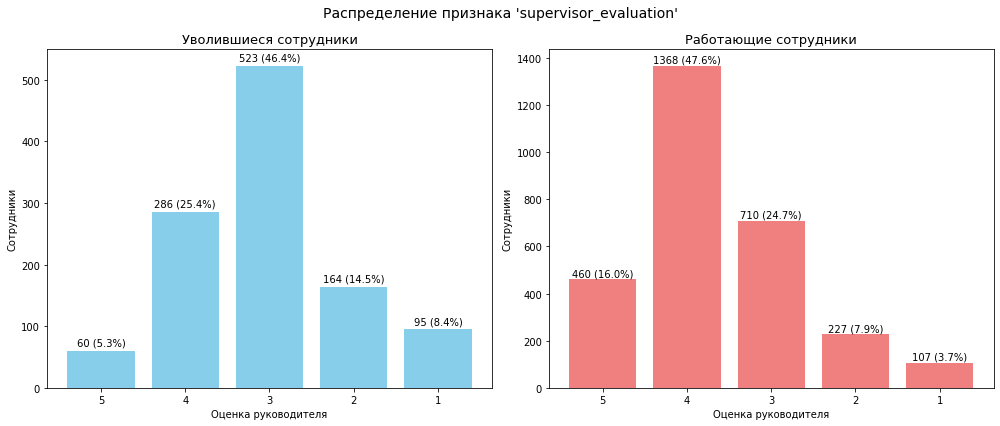

In [60]:
def dual_bar_chart(df1, df2, column, xlabel):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    plt.suptitle(f"Распределение признака '{column}'", fontsize=14)
    
    for ax, df in zip(axs, [df1, df2]):
        values = df[column].value_counts().sort_index(ascending=False)
        total_count = df[column].count()
        bars = ax.bar(range(len(values)), values, color='skyblue' if ax == axs[0] else 'lightcoral')
        ax.set_title('Уволившиеся сотрудники' if ax == axs[0] else 'Работающие сотрудники', fontsize=13)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Сотрудники')
        
        for i, (index, value) in enumerate(values.sort_index(ascending=False).items()):
            abs_value = value
            percent_value = value / total_count * 100
            ax.text(i, value + 5, f'{abs_value} ({percent_value:.1f}%)', ha='center', va='bottom', fontsize=10)
        
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels(values.index)
    
    plt.tight_layout()
    plt.show()

dual_bar_chart(train_yes, train_no, 'supervisor_evaluation', 'Оценка руководителя')

Можем что среди уволившихся почти 50 % сотрудников получили оценку "3" и было очень мало отличников. У оставшихся сотрудников наиболее популярная оценка "4" и почти в 8 раз больше отличников.

### Уровень должности `level`

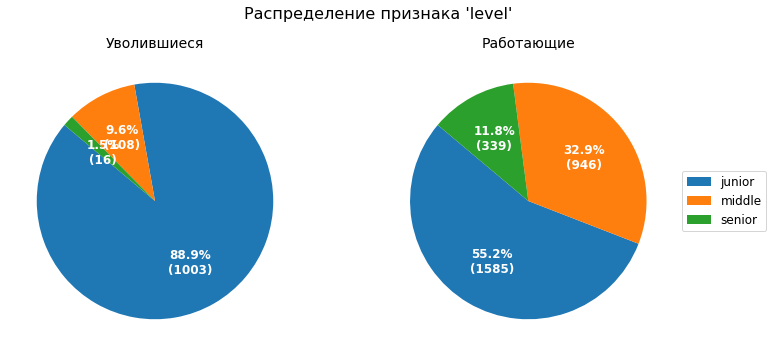

In [61]:
plot_pie_chart2(train_yes, train_no, 'level')

В компании наблюдается большая текучка джунов. Количество опытных сотрудников среди уволившихся около 10%, а среди оставшихся почти половина. Понятно теперь, для чего им такой большой HR департамент :)

### Уровень загруженности `workload`

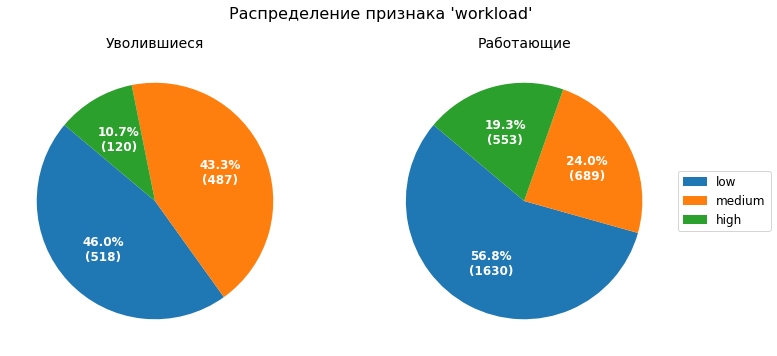

In [62]:
plot_pie_chart2(train_yes, train_no, 'workload')

Неожиданные цифры по нагрузке: среди уволившихся значительно больше людей со средней загрузкой, чем среди оставшихся. И в челом нагрузка у оставшихся меньше, чем у уволившихся.

### Уровень удовлетворенности `job_satisfaction_rate`

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это, оценив распределение `job_satisfaction_rate` на тестовых выборках для ушедших и оставшихся сотрудников. 

In [63]:
y_test_satisfaction.set_index('id', inplace=True)
y_test_satisfaction = y_test_satisfaction.sort_index()
y_test_satisfaction.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


In [64]:
y_test_quit.set_index('id', inplace=True)
y_test_quit = y_test_quit.sort_index()
y_test_quit.head()

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


Объединим признаки во временный датафрейм:

In [65]:
quit_satisfaction = y_test_satisfaction.merge(y_test_quit, on='id')
quit_satisfaction.head()

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


Поскольку нам необходимо рассчитать корреляцию между количественным и категорийным признаками, воспользуемся функцией phik_matrix.

In [66]:
phik_corr_matrix = phik_matrix(quit_satisfaction)
phik_corr_matrix

interval columns not set, guessing: ['job_satisfaction_rate']


,job_satisfaction_rate,quit
job_satisfaction_rate,1.000000,0.610263
quit,0.610263,1.000000


Между признаками имеется сильная взаимосвязь 0.61. Построим графики для ушедших и оставшихся сотрудников:

,df1,df2
count,564.00,1436.00
mean,0.39,0.61
std,0.19,0.20
min,0.04,0.03
25%,0.24,0.50
50%,0.37,0.66
75%,0.49,0.76
max,0.97,1.00


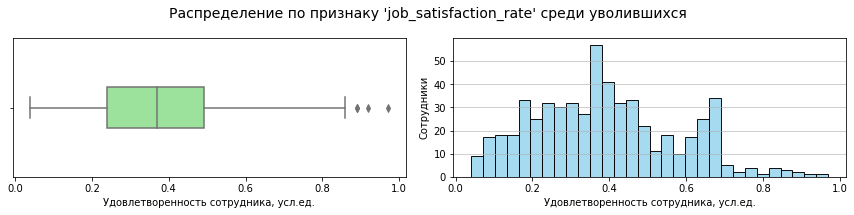

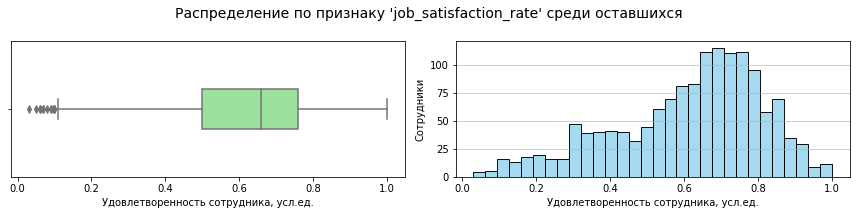

In [67]:
quit_yes = quit_satisfaction[quit_satisfaction['quit'] == 'yes']
quit_no = quit_satisfaction[quit_satisfaction['quit'] == 'no']

hist_and_boxplot2(quit_yes, quit_no, 'job_satisfaction_rate', 'Удовлетворенность сотрудника, усл.ед.')


Медианное значение удовлетворенности среди ушедших сотрудников почти вдвое меньше, чем среди оставшихся:0,38 против 0,66. По графикам и рассчитанным описательным статистикам хорошо заметно, что оставшиеся сотрудники более довольны своей работой, чем ушедшие. 

Все это позволяет сделать вывод, что между удовлетворенностью сотрудника и возможностью увольнения действительно есть сильная отрицательная связь. Чем ниже удовлетворенность, тем выше вероятность увольнения. Таким образом, нам необходимо добавить новый признак в датасет перед моделированием.

### Новый признак `job_satisfaction_rate_pred`

Предварительно перенесем id в индексы и удалим полные дубли:

In [68]:
train_quit.set_index('id', inplace=True)
train_quit = train_quit.drop_duplicates().sort_index()
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes
101374,technology,middle,low,8,no,no,3,22800,no
102155,technology,middle,high,8,no,no,4,57600,no


Добавим в тренировочную и тестовую выборки новый признак `job_satisfaction_rate_pred`

In [69]:
train_quit['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(train_quit)
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.318375
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.481899
100858,sales,junior,medium,2,no,no,4,25200,yes,0.613327
101374,technology,middle,low,8,no,no,3,22800,no,0.475044
102155,technology,middle,high,8,no,no,4,57600,no,0.703101


У тестовой выборки только перенесем id в индексы, но не будем удалять дубликаты:

In [70]:
X_test_quit.set_index('id', inplace=True)

Добавим `job_satisfaction_rate_pred`:

In [71]:
X_test_quit['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(X_test_quit)
X_test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.757157
686555,hr,junior,medium,1,no,no,4,30000,0.638204
467458,sales,middle,low,5,no,no,4,19200,0.553674
418655,sales,middle,low,6,no,no,4,19200,0.585391
789145,hr,middle,medium,5,no,no,5,40800,0.783340


In [72]:
X_train_quit = train_quit.drop(['quit'], axis=1).sort_index()
y_train_quit = train_quit['quit'].to_frame().sort_index()

X_test_quit = X_test_quit.sort_index()
y_test_quit = y_test_quit.sort_index()


## Корреляционный анализ данных

Рассмотрим матрицы корреляций для ушедших и оставшихся сотрудников на тренировочной выборке

In [73]:
quit_yes = train_quit[train_quit['quit'] == 'yes']
quit_no = train_quit[train_quit['quit'] == 'no']

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']


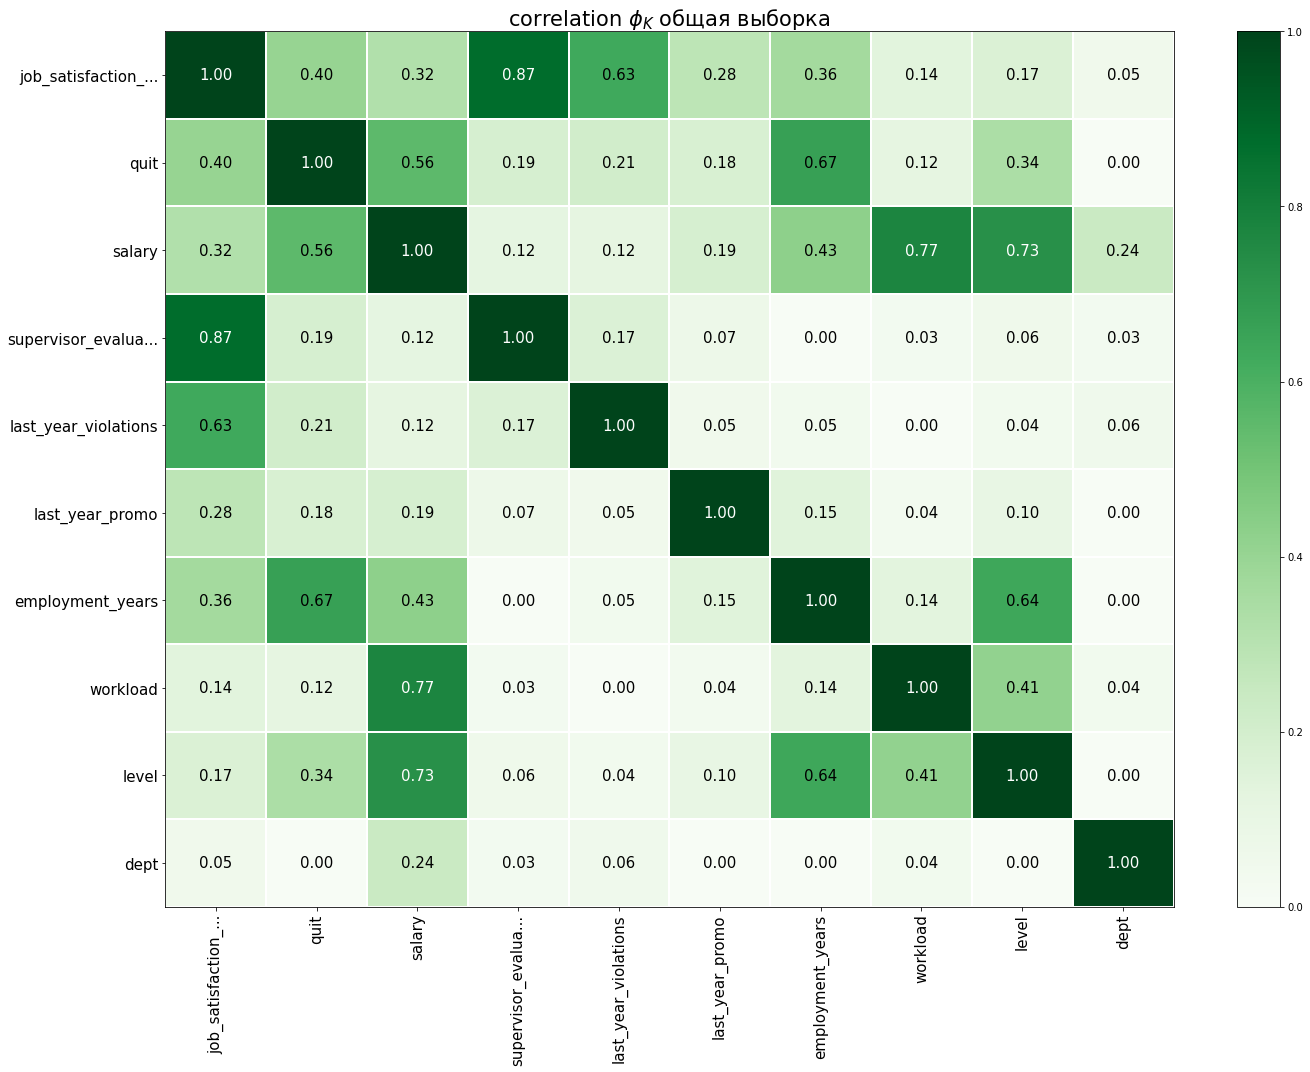

In [74]:
phik_overview = train_quit.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ общая выборка',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

1. На данной выборке корреляция между уходом сотрудника и предсказанной удовлетворенностью составляет 0.4, и это ниже, чем было на  выборке с реальными значениями `job_satisfaction_rate_pred`, где коэффициент был 0,61.
2. Отмечаем сильную взаимосвязь увольнения сотрудника с длительностью работы в компании и зарплатой. 
3. Отсутствует взаимосвязь с отделом, и очень низкая корреляция отмечается с загрузкой и 

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


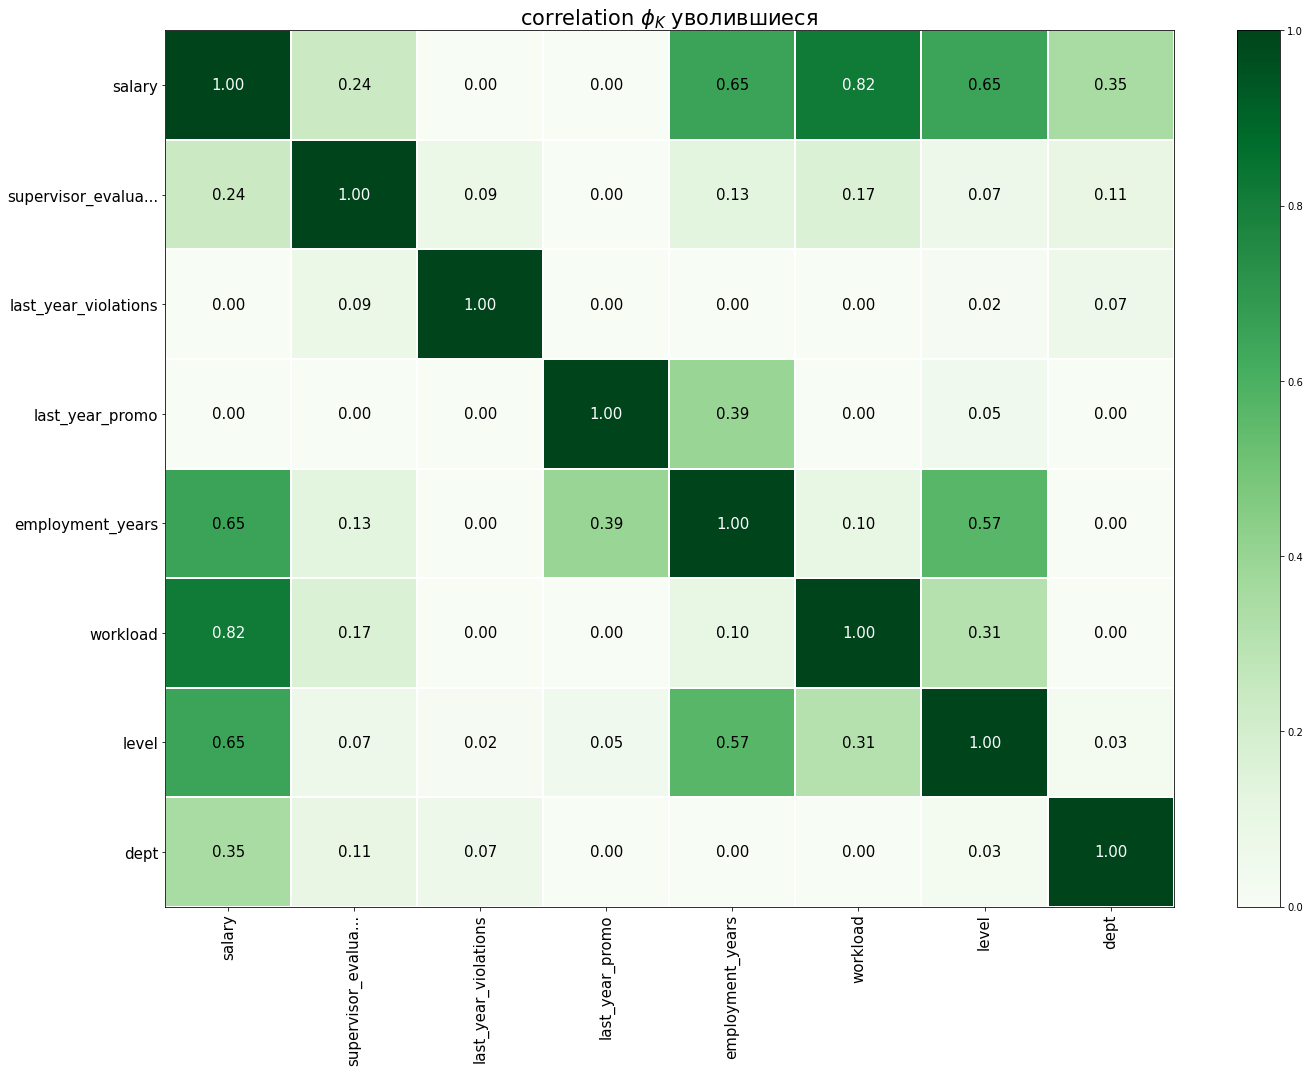

In [75]:
phik_overview = train_yes.drop(['id'], axis=1).phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ уволившиеся',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


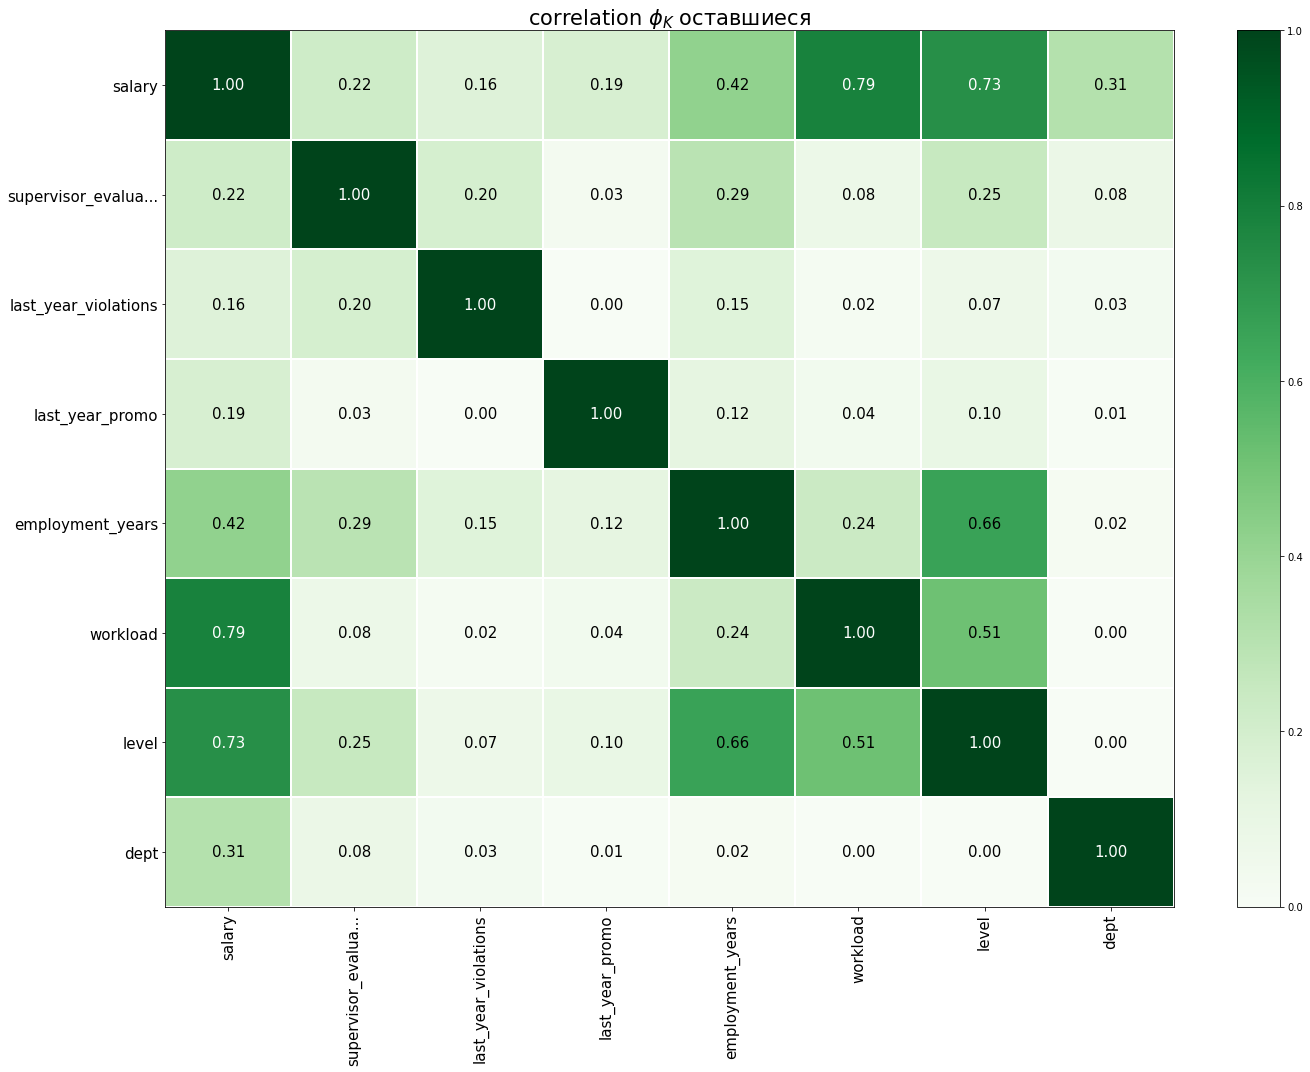

In [76]:
phik_overview = train_no.drop(['id'], axis=1).phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ оставшиеся',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Из сравнения матриц корреляции для уволившихся и оставшихся сотрудников можно вынести несколько наблюдений:

Замечено, что уволившихся сотрудников длительность и зарплата связаны друг с другом сильнее, чем у оставшихся.

Также видно, что уволившихся сотрудников сильнее взаимосвязь между наличием повышения за последний год и длительностью работы.

Кроме того, загрузка немного сильнее связана с зарплатой у уволившихся сотрудников. 

## Портрет типичного уволившегося сотрудника


Исходя из полученных данных, составим характерные черты уволившегося сотрудника:
1. Чаще всего это новичок, отработавший менее 1-2 лет
2. Зарплата уволившегося сотрудника по медиане примерно на треть меньше, чем у оставшегося сотрудника.
3. Не обнаружилось никакой закономерности между увольнением и отделом компании. 
4. Сотрудник имеет нарушения трудового договора чаще, чем оставшийся
5. Уволившийся сотрудник не имеет повышений за последний год
6. Самая частая оценка у уволившегося — 3, и у него реже, чем у оставшегося стоят пятерки
7. Чаще всего уволившийся  — сотрудник уровня junior.
8. По уровню загрузки нет ярко выраженных закономерностей.
9. Уволившийся сотрудник гораздо меньше удовлетворен работой, чем оставшийся сотрудник.

## Выводы перед обучением модели для второй задачи

Для решения второй задачи получены тренировочные данные `train_quit`, те же самые входные признаки  тренировочной выборки `X_test_satisfaction` и целевой признак тестовых данных `y_test_quit`

Переведены в индексы `id` сотрудников. Из тренировочной выборки удалены полные дубликаты. Дополнительная предобработка данных не требовалась. 

Проведен исследовательский анализ данных. Рассмотрены графики и описательные характеристики для двух классов сотрудников: кто уволился и кто остался. Составлен портрет типичного уволившегося сотрудника. Наиболее яркими признаками стала длительность работы в компании, профессиональный уровень, наличие нарушений и уровень удовлетворенности.

Вывод: данные адекватные, аномальные значения отсутствуют и датасеты готовы к обучению модели.  

## Поиск и обучение модели

Укажем необходимые столбцы (для подготовки воспользуемся уже созданным ранее пайплайном)

In [77]:
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['salary', 'employment_years', 'job_satisfaction_rate']

Выполним кодирование целевого признака методом LabelEncoder, так как он хорошо подходит для бинарных признаков.

In [78]:
label_encoder = LabelEncoder()
y_train_quit = label_encoder.fit_transform(y_train_quit)
y_test_quit = label_encoder.transform(y_test_quit)

Зададим список моделей и гиперпараметров:

In [79]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf'
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

Выполним рандомизированный поиск:

In [80]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_quit, y_train_quit)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'senior'],
                                                                                                                           ['low',
                                                                                                                            'me...
                                         'models__n_neighbors': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

Получим лучшую модель и ее параметры:

In [81]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                               

Оценим качество модели на тестовой выборке:

In [82]:
y_test_proba = randomized_search.predict_proba(X_test_quit)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_quit, y_test_proba), 3)}')

Метрика ROC-AUC на тестовой выборке: 0.905


Модель дает довольно точные предсказания, но наша задача улучшить ее. Проанализируем важность признаков для модели и примем решение об удалении незначимых признаков.

<AxesSubplot:ylabel='Feature'>

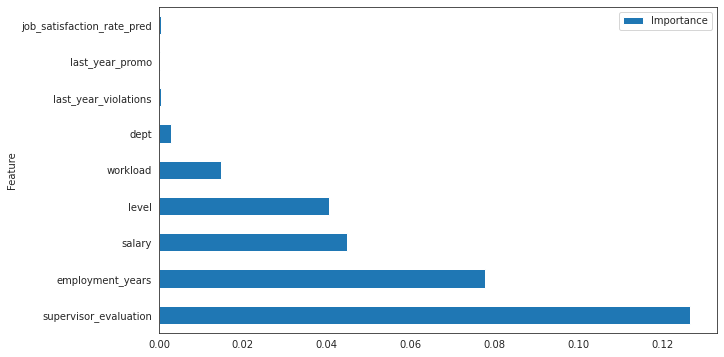

In [83]:
best_model = randomized_search.best_estimator_

# Оценка важности признаков с помощью permutation feature importance
result = permutation_importance(best_model, X_test_quit, y_test_quit, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

# Создание DataFrame с важностью признаков
feature_importance = pd.DataFrame({'Feature': X_test_quit.columns, 'Importance': result.importances_mean})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Преобразование значений важности в абсолютные
feature_importance['Importance'] = np.abs(feature_importance['Importance'])

# Построение графика важности признаков с абсолютными значениями
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Видим, что для модели маловажными оказались три признака: `last_year_promo`, `supervisor_evaluation`, `job_satisfaction_rate`. Попробуем избавиться от них и проверим, как изменится качество модели

In [84]:
X_train_cropped = X_train_quit.drop(['last_year_violations','last_year_promo','job_satisfaction_rate_pred'], axis=1)
X_test_cropped = X_test_quit.drop(['last_year_violations', 'last_year_promo','job_satisfaction_rate_pred'], axis=1)

Подготовим данные, выполним рандомизированный поиск и оценим качество новой модели:

In [85]:
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['salary', 'employment_years']

ord_pipe = Pipeline(
    [
        (
            'ord', 
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5]
                    
                ], 
                handle_unknown='use_encoded_value', 
                unknown_value=np.nan
            )
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf'
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train_cropped, y_train_quit)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'senior'],
                                                                                                                           ['low',
                                                                                                                            'medium',
                                                                                                                            'high'],
                                                                                                                           [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            4,
                                                                                                                            5]],
                                                                                                               handle_unknown...
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [86]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', round(randomized_search.best_score_, 3))

y_test_proba = randomized_search.predict_proba(X_test_cropped)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_quit, y_test_proba), 3)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                   

Такой показатель подходит. В итоге, лучшей моделью для предсказания увольнения сотрудника является DecisionTreeClassifier с параметрами max_depth=5, max_features=5, random_state=42 

## Общий вывод

**Описание задачи**

Перед нами стояла задача построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика и другую модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


Предсказать удовлетворенность сотрудника — это задача регрессии. Поэтому выбор стоял между деревом решений DecisionTreeRegressor с различными диапазонами гиперпараметров и моделью линейной регрессии LogisticRegression.

Предсказание уволится ли сотрудник — это задача бинарной классификации. Здесь мы выбирали между четыремя вариантами: дерево решений DecisionTreeClassifier, метод k-ближайших соседей KNeighborsClassifier, модель логистической регрессии LogisticRegression и метод опорных векторов SVC.   

**Выполнен исследовательский и корреляционный анализ данных**

Перед поиском и обучением моделей данные были подготовлены. Впервую очередь была выполнена предобработка данных: заполнены пропуски в данных, включая неявные, а также исправлена опечатка в значении столбца `level`. Переведены в индексы `id` сотрудников. После этого из тренировочных выборок удалены полные дубликаты для избежания снижения качества модели.

В обеих задачах проведен исследовательский анализ данных. Рассмотрены графики и описательные характеристики для тренировочной и тестовой выборок. Аномальные значения в датасетах отсутствуют. В задаче классификации у целевого показателя наблюдается дисбаланс классов. Но клиент корректно поделил данные на выборки с учетом стратификации.

На основании исследовательского и корреляционного анализа следаны следующие выводы:

1. На графике целевого признака `job_satisfaction_rate` присутствуют признаки бимодальности. По итогу исследования определено, что скорее всего это распределения удовлетворенности уволившихся и оставшихся сотрудников. Медианное значение признака без деления на сегменты — 0,56. Важно учитывать, что это плохо описывает ситуацию, так как у уволившихся и оставшихся сотрудников слишком большая разница в показателе  —  0,37 и 0,66 соответственно. Поэтому для полноты картины при таких исследованиях рекомендуется рассматривать разные сегменты сотрудников.   

2. Имеется взаимосвязь между длительностью работы, удовлетворенность и возможным увольнением. Чем дольше работает сотрудник тем вероятнее, что он удовлетворен и не собирается увольняться.

3. Ежемесячная зарплата имеет связь с увольнением, но вообще ничего не говорит об удовлетворенности сотрудника своей работой. 

4. Отдел, в котором работает сотрудник, не имеет каких-то значимых взаимосвязей с другими признаками.

5. Среди уволившихся сотрудников почти вдвое больше тех, кто имел нарушения трудового договора (целых 20% против 11% среди оставшихся).

6. Повышения имеются только у оставшихся соторудников.

7. Оставшиеся сотрудники получают более высокие оценки. Причем замечено, что имеется высокая взаимосвязь между удовлетворенностью работой и удовлетворенностью руководителя сотрудником. Тем не менее, как оказалось, мнение руководства почти не влияет на наличие повышения за год.

8. Больше всего в компании сотрудников уровня junior, они же и увольняются значительно чаще остальных. Эти данные дополняет статистика по длительности работы в компании: чаще всего увольняются люди, проработавшие не больше 2 лет. В то же время, если сотрудник продержался больше двух лет, высока вероятность, что он проработает все несколько лет. Также компанию покидает единичное число senior специалистов. 

9. Данные корреляционного анализа показывают, что на длительность работы в компании у уволившихся зарплата влияла сильнее, чем у оставшихся, также у уволившихся сильнее взаимосвязь между наличием повышения за последний год и длительностью работы. Кроме того, загрузка немного сильнее связана с зарплатой у уволившихся сотрудников. 

**Составлен портрет типичного уволившегося сотрудника:**

1. Чаще всего это новичок, отработавший менее 1-2 лет
2. Зарплата уволившегося сотрудника по медиане примерно на треть меньше, чем у оставшегося сотрудника.
3. Не обнаружилось никакой закономерности между увольнением и отделом компании. 
4. Сотрудник имеет нарушения трудового договора чаще, чем оставшийся
5. Уволившийся сотрудник не имеет повышений за последний год
6. Самая частая оценка у уволившегося — 3, и у него реже, чем у оставшегося стоят пятерки
7. Чаще всего уволившийся  — сотрудник уровня junior.
8. По уровню загрузки нет ярко выраженных закономерностей.
9. Уволившийся сотрудник гораздо меньше удовлетворен работой, чем оставшийся сотрудник.

**Выполнен рандомизированный поиск лучшей модели для предсказания удовлетворенности сотрудника**

Перед поиском выполнено масштабирование признаков: `job_satisfaction_rate`, `employment_years` и `salary`. Закодированы методом OneHotEncoder категорийные номинальные признаки: `dept`, `last_year_violations`, `last_year_promo`. Категорийные ранговые закодированы методом OrdinalEncoder: `supervisor_evaluation`, `level`, `workload`.

Поиск первой модели был выполнен с помощью решетчатого подхода GridSearchCV для перебора всех комбинаций гиперпараметров. Этот метод был использован так как в нашем случае таких комбинаций было не очень много. Поиск лучшей модели был выполнен с применением кросс-валидации с 5 выборками. 

Качество модели оценивалось с помощью показателя SMAPE. Лучшей оказалась модель линейной регрессии. Метрика SMAPE лучшей модели на валидационной выборке: 12.497. Метрика SMAPE на тестовой выборке равна: 11.781. Это значит, что на тестовой выборке модель ошиблась в предсказаниях в среднем на 11.781%. 

Для сравнения на тестовых данных была обучена константная модель DummyRegressor, которая в качестве предсказаний выдает среднее значение. Точность нашей модели оказалось выше точности константной модели на 60% (11.781 против 18.903).

**Выполнен рандомизированный поиск лучшей модели для предсказания увольнения сотрудника**

Кодирование и масштабирование входных признаков было выполнено аналогично первой задачи. Целевой признак был закодирован методом LabelEncoder, подходящим для бинарных категорийных признаков.

Так как мы хотели перебрать достаточно большое количество моделей и параметров, принято решение воспользоваться случайным поиском RandomizedSearchCV для экономии времени и ресурсов. 

Первая модель KNeighborsClassifier(n_neighbors=18) выдала на тестовой выборке точность, меньше условленной в задаче — 0,905. Было решено оценить значимость признаков и удалить наименее ценные. Оценка выполнена методом Permutation Importance. Маловажными оказались три признака: `last_year_promo`, `supervisor_evaluation`, `job_satisfaction_rate`.

В результате лучшей моделью стало дерево решений DecisionTreeClassifier(max_depth=5, max_features=5, random_state=42) с точностью на тестовой выборке 0.911. 

**Рекомендации**

Результаты исследования показывают, что большое количество сотрудников используют компанию как точку старта или даже школу. Если компания нацелена на взращивание и сохранение молодых специалистов, необходимо создавать условия, в которых способные сотрудники уровня junior предпочтут остаться в компании, как только получат первый опыт.  

Как показывает исследование, на решение уволиться оказывают влияние зарплата и наличие карьерного роста, а также нагрузка. Вероятно, у большого количества уволившихся junior-специалистов за 1-2 года выросли скиллы, но рост зарплаты, грейда или должности произошел несвоевременно или не произошел вовсе, но при этом начала расти нагрузка. Это привело к увольнению и, вероятно, поиску места с более привлекательными условиями.




